In [1]:
import json
import glob
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd

In [3]:
from collections import Counter,OrderedDict

In [4]:
def represent_odict(dumper, instance):
     return dumper.represent_mapping(u'tag:yaml.org,2002:map', instance.items())

yaml.add_representer(OrderedDict, represent_odict)

def construct_odict(loader, node):
    return OrderedDict(loader.construct_pairs(node))

yaml.add_constructor(u'tag:yaml.org,2002:map', construct_odict)

In [5]:
def ea(domain="DCM",threshold=0.0,directory=""):
    results = {
        'O':{'O':[],'T':[],'X':[]},
        'T':{'O':[],'T':[],'X':[]},
        'X':{'O':[],'T':[],'X':[]}
    }
    ref_paths = glob.glob("../dbdc3_jp_eval_allOs/"+domain+"/*.json")
    pred_paths = glob.glob(directory+domain+"/*.json")

    refs = [json.load(open(ref)) for ref in ref_paths]
    preds = [json.load(open(ref)) for ref in pred_paths]

    refs = sorted(refs,key = lambda x: x['dialogue-id'])
    preds = sorted(preds,key = lambda x: x['dialogue-id'])

    for ref,pred in zip(refs,preds):
        #print("------------dialogue-id :",ref['dialogue-id'],"------------")
        for i in range(0,len(ref['turns']),2):
            labels = ("O","T","X")
            user = "" if i == 0 else ref['turns'][i-1]['utterance']
            system = ref['turns'][i]['utterance']
            pred_dict = pred['turns'][int(i/2)]['labels'][0]

            breakdown_pred = pred_dict['breakdown']
            dist_pred = [pred_dict['prob-O'],pred_dict['prob-T'],pred_dict['prob-X']]
            dist_pred = list(map(float,dist_pred))
            dist_pred = [round(x,2) for x in dist_pred]
            annts_all = ref['turns'][i]['annotations']
            annts = [elem['breakdown'] for elem in annts_all]
            count = Counter(annts)
            dist_ref = np.array([count[label] for label in labels])
            dist_ref = dist_ref / np.sum(dist_ref)

            prob_O,prob_T,prob_X = dist_ref

            if prob_O >= prob_T and prob_O >= prob_X and prob_O >= threshold:
                breakdown_ref = "O"
            elif prob_T >= prob_O and prob_T >= prob_X and prob_T >= threshold:
                breakdown_ref =  "T"
            elif prob_X >= prob_T and prob_X >= prob_O and prob_X >= threshold:
                breakdown_ref =  "X"
            else:
                breakdown_ref =  "O"
            dist_ref = [round(float(x),2) for x in dist_ref]
            
            
            internal_result = OrderedDict([
                ('dialogue-id',ref['dialogue-id']),
                ('turn',i),
                ('user',user),
                ('system',system),
                ('reference_proba', dist_ref),
                ('predict_proba',dist_pred),
                
            ])
            results[breakdown_ref][breakdown_pred].append(internal_result)
    return results

In [6]:
def ea_df(domain="DCM",threshold=0.0,directory="./result/"):
    results = []
    ref_paths = glob.glob("../dbdc3_jp_eval_allOs/"+domain+"/*.json")
    pred_paths = glob.glob(directory+domain+"/*.json")

    refs = [json.load(open(ref)) for ref in ref_paths]
    preds = [json.load(open(ref)) for ref in pred_paths]

    refs = sorted(refs,key = lambda x: x['dialogue-id'])
    preds = sorted(preds,key = lambda x: x['dialogue-id'])

    for ref,pred in zip(refs,preds):
        #print("------------dialogue-id :",ref['dialogue-id'],"------------")
        for i in range(0,len(ref['turns']),2):
            labels = ("O","T","X")
            user = "" if i == 0 else ref['turns'][i-1]['utterance']
            system = ref['turns'][i]['utterance']
            pred_dict = pred['turns'][int(i/2)]['labels'][0]

            breakdown_pred = pred_dict['breakdown']
            dist_pred = [pred_dict['prob-O'],pred_dict['prob-T'],pred_dict['prob-X']]
            dist_pred = list(map(float,dist_pred))
            dist_pred = [round(x,2) for x in dist_pred]
            annts_all = ref['turns'][i]['annotations']
            annts = [elem['breakdown'] for elem in annts_all]
            count = Counter(annts)
            dist_ref = np.array([count[label] for label in labels])
            dist_ref = dist_ref / np.sum(dist_ref)

            prob_O,prob_T,prob_X = dist_ref

            if prob_O >= prob_T and prob_O >= prob_X and prob_O >= threshold:
                breakdown_ref = "O"
            elif prob_T >= prob_O and prob_T >= prob_X and prob_T >= threshold:
                breakdown_ref =  "T"
            elif prob_X >= prob_T and prob_X >= prob_O and prob_X >= threshold:
                breakdown_ref =  "X"
            else:
                breakdown_ref =  "O"
            dist_ref = [round(float(x),2) for x in dist_ref]
            
            
            internal_result = OrderedDict([
                ('domain',domain),
                ('dialogue-id',ref['dialogue-id']),
                ('turn',i),
                ('user',user),
                ('system',system),
                ('annotation_dist', dist_ref),
                ('pred_proba',dist_pred),
                ('annotation_bd', breakdown_ref),
                ('pred_bd', breakdown_pred)
                
            ])
            results.append(internal_result)
    return pd.DataFrame(results)

In [7]:
def ea_df_all(threshold=0.0,opt="",modelname="direct",directory="./directory/"):
    import subprocess
    import sys
    #res = subprocess.run(["python3", "evaluate.py", str(opt),modelname],shell=False,stderr=subprocess.STDOUT)
    #print(res)
    return pd.concat([ea_df("DCM",directory=directory),ea_df("DIT",directory=directory),ea_df("IRS",directory=directory)]).reindex()

In [8]:
result_cnn = ea_df_all(directory="./cnn_submit/")
result_lstm = ea_df_all(directory="./lstm_submit/")
result_ens = ea_df_all(directory="./ens_submit/")

In [9]:
open("./CSV/result_cnn.csv",'w').write(result_cnn.to_csv())
open("./CSV/result_lstm.csv",'w').write(result_lstm.to_csv())
open("./CSV/result_ens.csv",'w').write(result_ens.to_csv())

176443

In [10]:
cnn_bad = result_cnn[(result_cnn.annotation_bd != result_cnn.pred_bd) & (result_lstm.annotation_bd == result_lstm.pred_bd)]

In [11]:
lstm_bad = result_lstm[(result_lstm.annotation_bd != result_lstm.pred_bd) & (result_cnn.annotation_bd == result_cnn.pred_bd)]

In [12]:
ens_bad = result_ens[(result_ens.annotation_bd != result_ens.pred_bd)]

In [13]:
from collections import Counter
cnn_bad_domain_count = Counter(cnn_bad.domain)
lstm_bad_domain_count = Counter(lstm_bad.domain)
dist_cnn_bad = np.array(list(cnn_bad_domain_count.values()))
dist_lstm_bad = np.array(list(lstm_bad_domain_count.values()))

In [14]:
from scipy.stats import ttest_ind,norm,kstest

In [15]:
def sigLev(p,t=None):
    message = "" if t == None else "t = " + str(t) + ", "
    levels = np.array([0.001,0.01,0.05,np.inf])
    index = np.where(p <  levels)[0][0]
    if index != len(levels) - 1:
        level = levels[index]
        message += "p = %s < %s より，有意水準 %s %%で有意"%(p,level,level * 100)
    else:
        message += "p = %s より，有意差なし"%(p)
    return message

In [569]:
cnn_bad_sys_len = np.array(list(map(len,tagger(cnn_bad.system,'word'))))
lstm_bad_sys_len = np.array(list(map(len,tagger(lstm_bad.system,'word'))))
cnn_bad_user_len = np.array(list(map(len,cnn_bad.user)))
lstm_bad_user_len = np.array(list(map(len,lstm_bad.user)))
user_len = list(map(len,result_cnn.user))
system_len = list(map(len,result_lstm.system))
print("CNNだけがミスしたデータの，システム応答の平均文字数 : ",np.mean(cnn_bad_sys_len))
print("LSTMだけがミスしたデータの，システム応答の平均文字数 : ",np.mean(lstm_bad_sys_len))
t,p = ttest_ind(cnn_bad_sys_len,lstm_bad_sys_len,equal_var=False)
print(sigLev(p))

CNNだけがミスしたデータの，システム応答の平均文字数 :  15.25
LSTMだけがミスしたデータの，システム応答の平均文字数 :  11.272727272727273
p = 0.023273047043317462 < 0.05 より，有意水準 5.0 %で有意


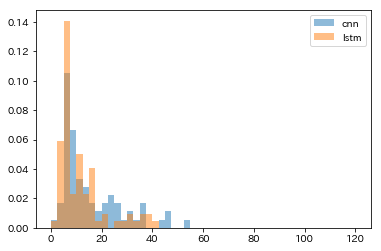

In [570]:
plt.hist(cnn_bad_sys_len,bins=48,alpha=0.5,range=(0,120),label='cnn',normed=True,)
plt.hist(lstm_bad_sys_len,bins=48,alpha=0.5,range=(0,120),label='lstm',normed=True)
plt.legend()
plt.show()

In [18]:
print(kstest(y,"norm"))

NameError: name 'y' is not defined

In [19]:
open("./CSV/result_ens.csv","w").write(result_ens.to_csv())

176443

In [20]:
def confusion(results,title):
    labels = ["O","T",'X']
    matrix = np.array([[len(results[r][p]) for p in labels] for r in labels])
    #matrix = matrix/ np.sum(matrix,axis=1).reshape(1,-1).transpose()
    plt.figure(figsize = (10,7))
    plt.title(title)
    plt.xlabel("Gold label")
    plt.ylabel("Predict")
    sns.heatmap(matrix, annot=True,fmt='g', cmap='Blues',xticklabels=labels,yticklabels=labels)
    plt.savefig("./ConfusionMatrix/"+title+".png")
    plt.show()

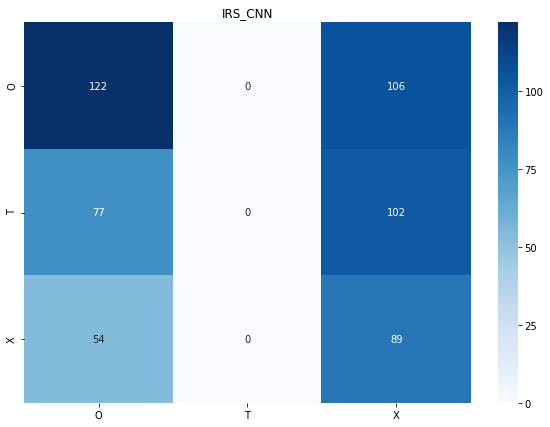

In [21]:
confusion(ea("DCM",directory="./result_ens/"),"IRS_CNN")

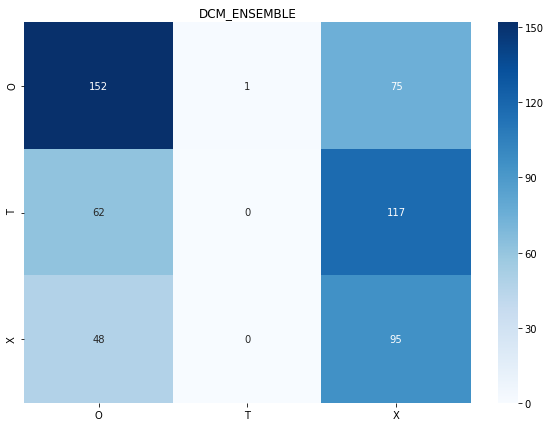

In [22]:
confusion(ea("DCM",directory="./result_nomoto/"),"DCM_ENSEMBLE")

In [23]:
import pandas as pd

In [24]:
tmp = pd.read_pickle("./data/vecs.pickle")
tmp2 = pd.DataFrame(tmp['system'][:-1])
tmp2.columns = ['system-1']
tmp2.loc[-1] = [[]]
tmp2.index = tmp2.index + 1
tmp2 = tmp2.sort_index()
for i in range(0,len(tmp2),11):
    tmp2['system-1'][i] = np.array([])
df = pd.concat([tmp,tmp2],axis=1)

In [25]:
from preprocess_chainer import mk_minibatch

In [26]:
import json
import glob

In [27]:
fps_cnn = glob.glob("./result_conv_attn/DCM/*")
datas_cnn = sorted([json.load(open(fp)) for fp in fps_cnn],key=lambda x:x["dialogue-id"])

In [28]:
fps_rnn = glob.glob("./result_nomoto/DCM/*")
datas_rnn = sorted([json.load(open(fp)) for fp in fps_rnn],key=lambda x:x["dialogue-id"])

In [29]:
cnn_probs = []
rnn_probs = []
for cnn,rnn in zip(datas_cnn,datas_rnn):
    for turn_cnn,turn_rnn in zip(cnn['turns'],rnn['turns']):
        annt_cnn = turn_cnn['labels'][0]
        annt_rnn = turn_rnn['labels'][0]
        cnn_probs.append((annt_cnn['prob-O'],annt_cnn['prob-T'],annt_cnn['prob-X']))
        rnn_probs.append((annt_rnn['prob-O'],annt_rnn['prob-T'],annt_rnn['prob-X']))

In [30]:
cnn_probs = np.array(cnn_probs)

In [31]:
rnn_probs = np.array(rnn_probs)

In [152]:
np.random.seed(1)

In [153]:
#両方あってる
pd.set_option('display.max_rows',100)
both_true = result_cnn[(result_cnn.annotation_bd == result_cnn.pred_bd) & (result_lstm.annotation_bd == result_lstm.pred_bd)].reset_index(drop=True)
both_true_sampled = both_true.loc[np.random.randint(0,len(both_true),100),:]
both_true_sampled

,domain,dialogue-id,turn,user,system,annotation_dist,pred_proba,annotation_bd,pred_bd
37,DCM,1502868462,2,スイカは大好きだよ。,スイカは大好きですか。スイカは実が大きいですね,"[0.77, 0.2, 0.03]","[0.41, 0.23, 0.36]",O,O
235,DIT,1503630791,20,予防措置は大事ですよね。,羽生結弦選手と、JR東日本の内村航平選手との衝突で全治2週間から3週間ですからね。下手をする...,"[0.0, 0.27, 0.73]","[0.24, 0.27, 0.49]",X,X
72,DCM,1502868545,8,はい、大丈夫です。,予防が重要ですね,"[0.87, 0.1, 0.03]","[0.57, 0.18, 0.25]",O,O
767,IRS,1503291549,16,スイカ割したことありますか？,スイカの名産地？歌？,"[0.03, 0.2, 0.77]","[0.27, 0.28, 0.45]",X,X
715,IRS,1503291271,0,,こんにちは。あなたはいつも家では何をしてますか？,"[1.0, 0.0, 0.0]","[0.95, 0.03, 0.02]",O,O
645,IRS,1503291027,18,撮影に参加することはありません,楽しかったですねー。何せモデルがかわいいし。,"[0.17, 0.3, 0.53]","[0.27, 0.29, 0.44]",X,X
144,DCM,1502869024,0,,こんにちは！声かけてくれるのを待ってたんだ。,"[1.0, 0.0, 0.0]","[0.96, 0.02, 0.02]",O,O
129,DCM,1502868983,8,湖も楽しいですよ,湖は美しいですね,"[0.8, 0.13, 0.07]","[0.49, 0.23, 0.28]",O,O
583,IRS,1503290758,4,便利ですよね,てことは、PCから入れるんですよね？,"[0.0, 0.07, 0.93]","[0.24, 0.27, 0.49]",X,X
749,IRS,1503291483,18,賢い方法ですね、私もそうしてみます,はい。是非是非。地元は名古屋なんですか？,"[0.4, 0.37, 0.23]","[0.51, 0.17, 0.32]",O,O


In [154]:
#両方間違えた
pd.set_option('display.max_rows',100)
cond = (result_cnn.annotation_bd != result_cnn.pred_bd) & (result_lstm.annotation_bd != result_lstm.pred_bd)
both_false = result_cnn[cond].reset_index(drop=True)
both_false = both_false.rename(columns={'pred_bd': 'pred_CNN'})
both_false = both_false.join(result_lstm[cond].rename(columns={'pred_bd':'pred_LSTM'})['pred_LSTM'].reset_index(drop=True))
both_false_sampled = both_false.loc[np.random.randint(0,len(both_false),100),:]
both_false_sampled

,domain,dialogue-id,turn,user,system,annotation_dist,pred_proba,annotation_bd,pred_CNN,pred_LSTM
461,DIT,1503636384,2,大阪です,私の住んでいる大阪では全日本空輸の話題は朝のあいさつのようなものです。,"[0.2, 0.6, 0.2]","[0.29, 0.31, 0.41]",T,X,X
564,IRS,1503291238,6,5人くらいで組んで話すと楽しいですよね。,そのモードのなれば意外と早かったり、テーマがあれば言葉も出てきやすいですけど、。,"[0.23, 0.43, 0.33]","[0.27, 0.31, 0.42]",T,X,X
469,IRS,1503290559,6,私も好きです。少し前に朝ドラでもミスチル歌ってましたよね,ミスチルの中で一番好きな曲はなんですか？,"[0.83, 0.03, 0.13]","[0.3, 0.33, 0.37]",O,X,X
454,DIT,1503633022,8,おいしそうですね。けっこう手が込んでいるんですね。,ナゴヤドームの球場グルメには、いちごポッキーというのがあって、一度食べてみたいと思いました。,"[0.43, 0.37, 0.2]","[0.26, 0.33, 0.41]",O,X,X
514,IRS,1503290951,12,お酒は毎日飲みますか？,お酒は好きですよ。あまり飲めませんが・・・。,"[0.27, 0.5, 0.23]","[0.23, 0.33, 0.44]",T,X,X
588,IRS,1503291371,4,今日は暑いですね。,ここは暑いですね。,"[0.33, 0.43, 0.23]","[0.41, 0.24, 0.35]",T,O,X
149,DCM,1502868964,8,そうですね。あなたはどれが食べたいですか？,和食でヘルシーです,"[0.37, 0.47, 0.17]","[0.23, 0.3, 0.48]",T,X,X
263,DCM,1502873112,8,じゃあ私からいきますよ、リンゴ。,しりとりを楽しみましょうね,"[0.13, 0.53, 0.33]","[0.31, 0.27, 0.42]",T,X,O
77,DCM,1502868518,16,好きな本のタイトル教えてください。,話は変わりますけど、アメリカの学校の夏休みは三ヶ月もあるって知ってました？,"[0.17, 0.5, 0.33]","[0.17, 0.29, 0.55]",T,X,X
75,DCM,1502868492,18,一気に読みたいですよね,思い出したんですが、読書する習慣があるって言ってましたよね？歴史小説を読みたいですよねー,"[0.3, 0.5, 0.2]","[0.3, 0.32, 0.37]",T,X,X


In [159]:
import MeCab
from collections import Counter
m = MeCab.Tagger()

In [343]:
def tagger(data,kind="attr"):
    return [pos_surf(sent,kind) for sent in data]

In [344]:
def pos_surf(sent,kind):
    result = []
    for line in m.parse(sent).split("\n")[:-2]:
        surf,attrs = line.split("\t")
        attrs = attrs.split(",")
        if kind == "word":
            result.append(surf)
        else:
            if attrs[1] == "*":
                result.append(attrs[0])
            else:
                result.append(attrs[0] + "("+ attrs[1] +")")
    return result

In [315]:
def count(data):
    return sorted(Counter([word for sent in data for word in sent]).items(),key=lambda x:x[0])

In [543]:
def plt_count(data1,data2,kind='attr',label1="both_true",label2="both_false",figsize=(5,15)):
    both_true_len = np.array(list(map(len,data1.system)))
    both_false_len = np.array(list(map(len,data2.system)))

    bt_dict = dict(count(tagger(data1.system,kind)))

    bf_dict = dict(count(tagger(data2.system,kind)))

    sabunlist = list(set(bt_dict.keys()).symmetric_difference(set(bf_dict.keys())))

    for sabun in sabunlist:
        try:
            del bt_dict[sabun]
        except:
            pass
        try:
            del bf_dict[sabun]
        except:
            pass
    bf_word,bf_count = zip(*sorted(bf_dict.items(),key=lambda x:-bt_dict[x[0]]))
    bt_word,bt_count = zip(*sorted(bt_dict.items(),key=lambda x:-bt_dict[x[0]]))
    bf_count = np.array(bf_count)/ np.sum(bf_count)
    bt_count = np.array(bt_count)/ np.sum(bt_count)
    x = range(len(bt_count))



    plt.rcParams["font.family"] =  'TakaoPGothic'
    plt.rcParams["font.size"] = 10
    plt.figure(figsize=figsize)
    plt.barh(x[:100],bf_count[:100],alpha=0.5,label=label1)
    plt.barh(x[:100],bt_count[:100],alpha=0.5,label=label2)
    plt.legend()
    plt.yticks(x[:100],bt_word[:100])
    plt.show()

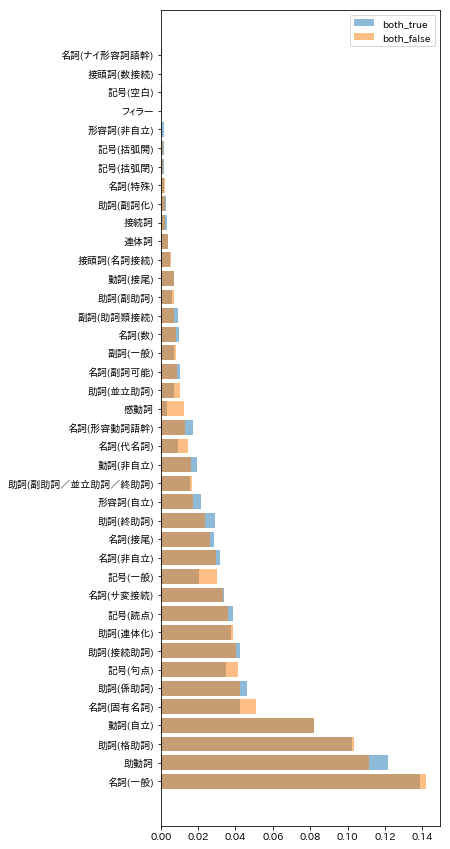

In [544]:
plt_count(both_true,both_false)

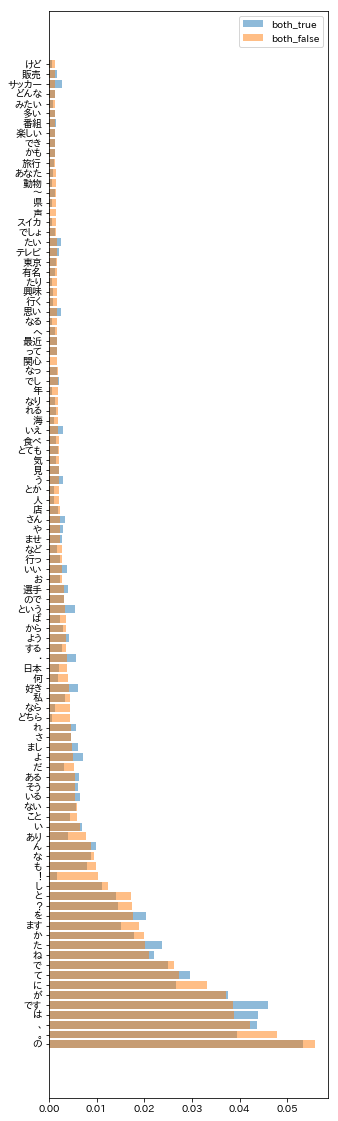

In [545]:
plt_count(both_true,both_false,kind='word',figsize=(5,20))

In [550]:
#unk率の調査
from gensim.models import Word2Vec
w2v = Word2Vec.load("./models/w2v/w2v_512.model")

bt_words = [word for sent in tagger(both_true.system,kind='word') for word in sent]
bf_words = [word for sent in tagger(both_false.system,kind='word') for word in sent]

bt_unks = [word not in w2v.wv.vocab for word in bt_words]
bf_unks = [word not in w2v.wv.vocab for word in bf_words]

#全文中何割がunkか
print("unk word率（両方正解）\t\t：",sum(bt_unks) / len(bt_unks))
print("unk word率（両方不正解）\t：",sum(bf_unks) / len(bf_unks))

unk word率（両方正解）		： 0.07509351400945727
unk word率（両方不正解）	： 0.0800698657841515


In [549]:
#平均unk数/文
bt_unk_sent = [sum([word not in w2v.wv.vocab for word in sent]) for sent in tagger(both_true.system,kind='word')]
bf_unk_sent = [sum([word not in w2v.wv.vocab for word in sent]) for sent in tagger(both_false.system,kind='word')]
print("unk word数/文（両方正解）\t:",sum(bt_unk_sent)/len(bt_unk_sent))
print("unk word数/文（両方不正解）\t:",sum(bf_unk_sent)/len(bf_unk_sent))
t,p = ttest_ind(bt_unk_sent,bf_unk_sent,equal_var=False)
print(sigLev(p))

unk word数/文（両方正解）	: 1.3676092544987146
unk word数/文（両方不正解）	: 1.4208809135399674
p = 0.5716149139557634 より，有意差なし


In [553]:
both_true_len = np.array(list(map(len,tagger(both_true.system,kind='word'))))
both_false_len = np.array(list(map(len,tagger(both_false.system,kind='word'))))
print("両方正解のデータの，システム応答の平均語数\t\t:",np.mean(both_true_len))
print("両方不正解のデータの，システム応答の平均語数\t:",np.mean(both_false_len))
t,p = ttest_ind(both_true_len,both_false_len,equal_var=False)
print(sigLev(p))

両方正解のデータの，システム応答の平均語数		: 18.212082262210796
両方不正解のデータの，システム応答の平均語数	: 17.745513866231647
p = 0.5288085935804958 より，有意差なし


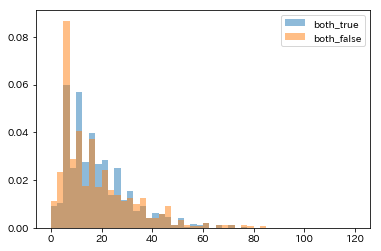

In [507]:
#文長ヒストグラム
plt.hist(both_true_len,bins=48,alpha=0.5,range=(0,120),label='both_true',normed=True,)
plt.hist(both_false_len,bins=48,alpha=0.5,range=(0,120),label='both_false',normed=True)
plt.legend()
plt.show()

In [508]:
#実際の正解に基づく調査
data_O = result_cnn[result_cnn.annotation_bd=="O"]
data_X = result_cnn[result_cnn.annotation_bd=="X"]

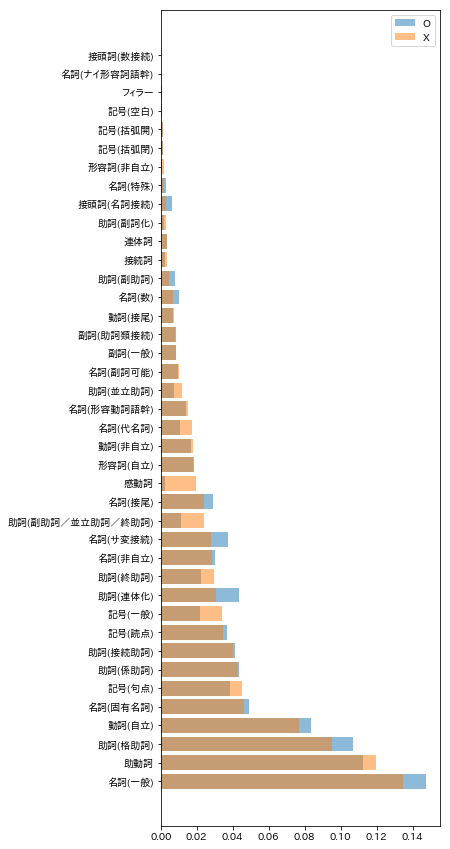

In [509]:
plt_count(data_O,data_X,kind='attr',label1='O',label2='X',figsize=(5,15))

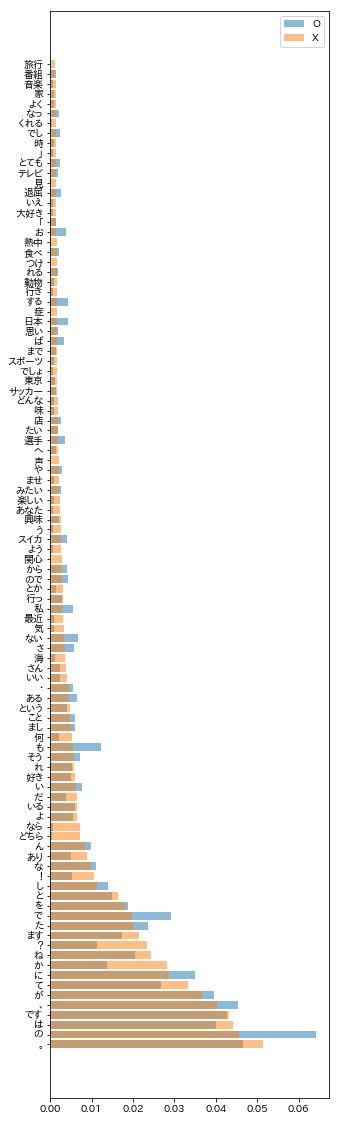

In [510]:
plt_count(data_O,data_X,kind='word',label1='O',label2='X',figsize=(5,20))

In [567]:
#システム発話の文長とユーザ発話の文長の平均絶対誤差
absdiff_O = np.array(list(map(len,data_O.system))) - np.array(list(map(len,data_O.user)))
absdiff_X = np.array(list(map(len,data_X.system))) - np.array(list(map(len,data_X.user)))
print("システム発話とユーザ発話の文長の平均絶対誤差（O）\t:",np.mean(absdiff_O))
print("システム発話とユーザ発話の文長の平均絶対誤差（X）\t:",np.mean(absdiff_X))
t,p = ttest_ind(absdiff_O,absdiff_X,equal_var=False)
print(sigLev(p))

システム発話とユーザ発話の文長の平均絶対誤差（O）	: 16.19097222222222
システム発話とユーザ発話の文長の平均絶対誤差（X）	: 19.336890243902438
p = 0.022544011020527683 < 0.05 より，有意水準 5.0 %で有意


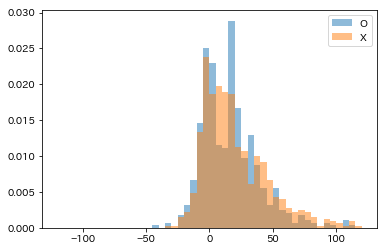

In [568]:
#システム発話とユーザ発話の文長の絶対誤差ヒストグラム
plt.hist(absdiff_O,bins=48,alpha=0.5,range=(-120,120),label='O',normed=True,)
plt.hist(absdiff_X,bins=48,alpha=0.5,range=(-120,120),label='X',normed=True)
plt.legend()
plt.show()

In [527]:
p

0.04050842727078406